# parPE example: steadystate model - hierarchical optimization

This notebooks demonstrates the use of parPE for parameter estimation using a recently developed hierarchical optimization approach (https://www.biorxiv.org/content/early/2018/01/15/247924).

The model and data used in this notebook are described in more detail in `parpeExampleSteadystateBasic.ipynb`.


## Prerequisites

The prerequisites mention in `parpeExampleSteadystateBasic.ipynb` also apply to this notebook.

In [1]:
import amici
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from importlib import reload

# set paths
parpe_source_root = os.path.abspath('../../../')
parpe_build_root = os.path.join(parpe_source_root, 'build') 

model_source_dir = f'{parpe_build_root}/examples/parpeamici/steadystate/steadystate_scaled-prefix/src/steadystate_scaled/model_steadystate_scaled'
example_binary_dir = f'{parpe_build_root}/examples/parpeamici/steadystate/'
example_data_dir = f'{parpe_build_root}/examples/parpeamici/steadystate/steadystate_scaled-prefix/src/steadystate_scaled'
optimizationOptionsPy = f'{parpe_source_root}/misc/optimizationOptions.py'

# load parpe module from source tree
sys.path.insert(0, os.path.join(parpe_source_root, 'python'))
import parpe

In [2]:
# rebuild example
!cd {parpe_build_root} && make

[  9%] Built target parpecommon
[ 20%] Built target parpeoptimization
[ 23%] Built target parpeloadbalancer
[ 35%] Built target parpeamici
[ 36%] Built target parpe
-- Found Git: /usr/bin/git (found version "2.20.1") 
-- Building version parPE-v0.3.0-51-g44ea9-dirty
[ 36%] Built target get_version
[ 42%] Built target unittests_common
[ 47%] Built target unittests_loadbalancer
[ 54%] Built target unittests_optimization
Setting up virtual environment...
[ 54%] Built target setup_venv
[ 55%] Creating test data using hierarchicalOptimizationTest.py
...
----------------------------------------------------------------------
Ran 3 tests in 0.000s

OK
[ 55%] Built target prepare_test_hierarchical_optimization
[ 63%] Built target unittests_amici
[ 65%] Built target example_loadbalancer
[ 76%] Built target steadystate_scaled
[ 79%] Built target example_steadystate_multi_simulator
[ 85%] Built target example_steadystate_parallel
[ 89%] Built target example_steadystate_multi
[ 92%] Built target ex

In [3]:
# run make test to generated all output files required below
#!cd {parpe_build_root} && make test

## Hierarchical optimization

Depending on the type of training data, the parameter estimation may contain a large number of output or nuisance parameters necessary to model the measurement process and transform model states to the actually measured quantity. These parameters are required for model parameterization, but don't affect the model states. This could for example be scaling parameters, in the case of relative measurements.

We recently developed an hierarchical optimization approach (https://www.biorxiv.org/content/early/2018/01/15/247924), that allows to analytically compute scaling, offset and sigma parameters. For large models, this can greatly improve optimizer convergence, and therefore, computation time.

### Optimize

In [4]:
hdf5_input_file_hierarchical = f'{example_data_dir}/example_data.h5'
hdf5_pe_output_file_hierarchical = 'deletemehierarchical/_rank00000.h5'

# Enabling hierarchical optimization in parPE is as easy as this: 
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s hierarchicalOptimization 1

# Set some additional options, independently of hierarchical optimization
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s numStarts 1
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s ipopt/max_iter 20
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s ipopt/acceptable_obj_change_tol 1e-5
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s ipopt/acceptable_tol 1e-5
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s retryOptimization 0

# Print current settings
!{optimizationOptionsPy} {hdf5_input_file_hierarchical}


                hierarchicalOptimization            1
                               numStarts            1
                               optimizer            0
                       retryOptimization            0
                ceres/max_num_iterations          100
                         fmincon/GradObj        b'on'
                     fmincon/MaxFunEvals   10000000.0
                         fmincon/MaxIter          100
                          fmincon/TolFun            0
                            fmincon/TolX        1e-08
                       fmincon/algorithm b'interior-point'
                         fmincon/display      b'iter'
                   ipopt/acceptable_iter            1
         ipopt/acceptable_obj_change_tol        1e-05
                    ipopt/acceptable_tol        1e-05
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                          ipopt/max_iter           20
                  

In [5]:
# Before starting the optimization, we can shortly compare the objective function gradients computed by AMICI/parPE with finite differences:
!PARPE_NO_DEBUG=1 {example_binary_dir}/example_steadystate_multi -t gradient_check -o deletemegc/ {hdf5_input_file_hierarchical}

HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
scalings [ 0.414383 ]
sigmas [ -0.458818 ]
scalings [ 0.414384 ]
sigmas [ -0.458818 ]
scalings [ 0.414383 ]
sigmas [ -0.458818 ]
[2019-05-29 11:23:50] [INF] [-1/]     0 g:      4.78189  fd_c:      4.74177  Δ/ff: 2.479117e-05  f:      1618.14
scalings [ 0.414383 ]
sigmas [ -0.458818 ]
scalings [ 0.414383 ]
sigmas [ -0.458818 ]
[2019-05-29 11:23:50] [INF] [-1/]     1 g:      62.9345  fd_c:      63.1094  Δ/ff: -1.080867e-04  f:      1618.14
scalings [ 0.414383 ]
sigmas [ -0.458818 ]
scalings [ 0.414383 ]
sigmas [ -0.458818 ]
[2019-05-29 11:23:50] [INF] [-1/]     2 g:      2.69438  fd_c:      2.67813  Δ/ff: 1.004075e-05  f:      1618.14
scalings [ 0.414383 ]
sigmas [ -0.458818 ]
scalings [ 0.414383 ]
sigmas [ -0.458818 ]
[2019-05-29 11:23:50] [INF] [-1/]     3 g:     -71.8093  fd_c:     -71.8562  Δ/ff: 2.897976e-05  f:      1618.14
scalings [ 0.414383 ]
sigmas [ -0.458818 ]
scalings [ 0.4

In [6]:
# Run the actual optimization (using MPI with 4 processes, 1 master, 3 workers)
!PARPE_NO_DEBUG=1 mpiexec -n 4 {example_binary_dir}/example_steadystate_multi  -o deletemehierarchical/ {hdf5_input_file_hierarchical}


[2019-05-29 11:23:50] [INF] [0/dweindl-ThinkPad-L480] Running with 4 MPI processes.
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2019-05-29 11:23:50] [INF] [0/dweindl-ThinkPad-L480] Reading random initial theta 0 from /optimizationOptions/randomStarts
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma

List of user-set options:

                                    Name   Value                used
                         acceptable_iter = 1                     yes
               acceptable_obj_change_tol = 1e-05                 yes
                          acceptable_tol =

scalings [ 0.323599 ]
sigmas [ -0.697992 ]
scalings [ 0.323599 ]
sigmas [ -0.697992 ]
[2019-05-29 11:23:53] [INF] [0/dweindl-ThinkPad-L480] [o0i14] iter: 14 cost: -370.786 time_iter: wall: 0.169779s cpu: 0.385345s time_optim: wall: 2.11853s cpu: 5.37066s
  14 -3.7078565e+02 0.00e+00 8.84e-01 -11.0 2.12e-01    -  1.00e+00 6.25e-02f  5
scalings [ 0.323042 ]
sigmas [ -0.697966 ]
scalings [ 0.323042 ]
sigmas [ -0.697966 ]
[2019-05-29 11:23:53] [INF] [0/dweindl-ThinkPad-L480] [o0i15] iter: 15 cost: -370.803 time_iter: wall: 0.125101s cpu: 0.33459s time_optim: wall: 2.24363s cpu: 5.70525s
  15 -3.7080297e+02 0.00e+00 8.86e-02 -11.0 1.68e-02    -  1.00e+00 1.00e+00f  1
scalings [ 0.32705 ]
sigmas [ -0.698229 ]
scalings [ 0.32705 ]
sigmas [ -0.698229 ]
scalings [ 0.32507 ]
sigmas [ -0.69811 ]
scalings [ 0.324062 ]
sigmas [ -0.698042 ]
scalings [ 0.323554 ]
sigmas [ -0.698005 ]
scalings [ 0.323298 ]
sigmas [ -0.697986 ]
scalings [ 0.323298 ]
sigmas [ -0.697986 ]
[2019-05-29 11:23:53] [INF] [0/d

### Analyze Results

array([[-249.01505902],
       [-286.2520608 ],
       [-360.98974244],
       [-366.43011867],
       [-368.93496102],
       [-369.14725797],
       [-369.51941317],
       [-369.57533748],
       [-369.75676662],
       [-370.01434364],
       [-370.1051099 ],
       [-370.13158852],
       [-370.71996037],
       [-370.78409957],
       [-370.78564965],
       [-370.80297138],
       [-370.80312557],
       [-370.80370967],
       [-370.80374697],
       [-370.80375911],
       [-370.80376242]])

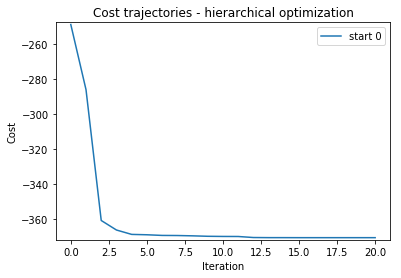

In [7]:
trajectories_hierarchical = parpe.getCostTrajectories(hdf5_pe_output_file_hierarchical)
ax = parpe.plotting.plotCostTrajectory(trajectories_hierarchical, scaleToIteration=0, log=False);
ax.set_title('Cost trajectories - hierarchical optimization')
trajectories_hierarchical

In [8]:
num_starts = trajectories_hierarchical.shape[1]
for start_idx in range(num_starts):
    parpe.compare_optimization_results_to_true_parameters(hdf5_pe_output_file_hierarchical, start_idx=start_idx)

#  __Exp____ __Act______ __Err______ __RelErr___ __ID_______
0:   1.00000     0.88195    -0.11805    -0.11805 p1
1:   0.50000     0.70469     0.20469     0.40937 p2
2:   0.40000     0.29613    -0.10387    -0.25967 p3
3:   2.00000     1.98674    -0.01326    -0.00663 p4
4:   0.10000     0.17498     0.07498     0.74976 p5
5:   2.00000     2.10515     0.10515     0.05257 scaling_x1_common
6:   3.00000     2.98368    -0.01632    -0.00544 offset_x2_batch-0
7:   0.20000     0.20046     0.00046     0.00231 x1withsigma_sigma
8:   4.00000     2.98951    -1.01049    -0.25262 offset_x2_batch-1

Status: 1
Cost: -370.803762 (expected: -0.000000)


In [9]:
!rm -f simh.h5
!{example_binary_dir}/example_steadystate_multi_simulator {hdf5_pe_output_file_hierarchical} / simh.h5 / --at-optimum

Running for start 0
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
Need to compute analytical parameters: //inputData  1 parameters.size() == 5 ; hierarchical.numParameters() == 5
Starting simulation. Number of conditions: 4


In [10]:
(measured, simulated, timepoints, llh) = parpe.readSimulationsFromFile('simh.h5')
start_idx = '0'

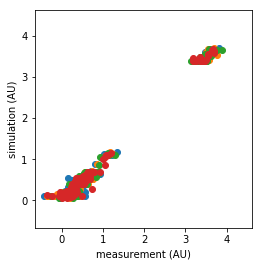

In [11]:
parpe.plotting.plotCorrelation(measured[start_idx], simulated[start_idx])

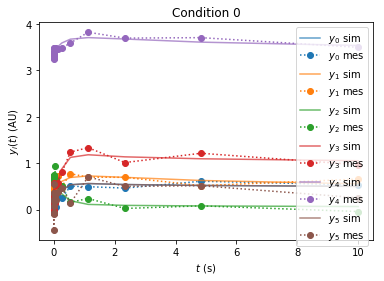

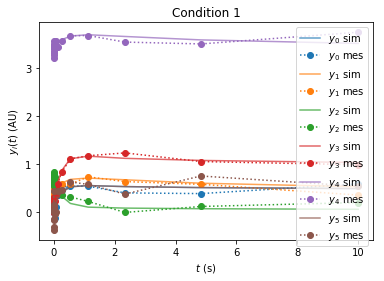

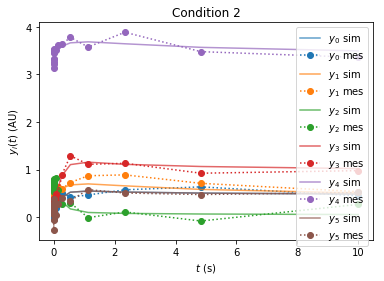

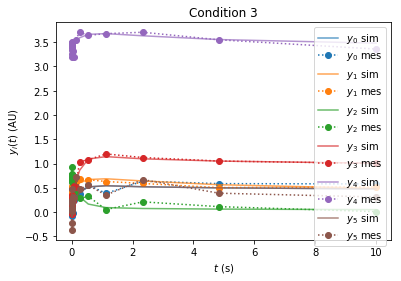

In [12]:
parpe.plotting.plotTrajectoryFits(measured[start_idx], simulated[start_idx], timepoints[start_idx])

## Standard optimization Ipopt

### Set parameter estimation options

Parameter estimation settings specified inside an HDF5 file. Those can be changed from any programming language with HDF5 bindings, with hdfview (https://www.hdfgroup.org/downloads/hdfview/), or with a helper script included in parPE, as demonstrated here:

In [13]:
# enable derivate checker
input_file = f'{example_data_dir}/example_data.h5'

# Perform two optimizer runs from different starting points
!{optimizationOptionsPy} {input_file} -s numStarts 1

# Disable hierarchical optimization
!{optimizationOptionsPy} {input_file} -s hierarchicalOptimization 0

# Print settings
!{optimizationOptionsPy} {input_file}

                hierarchicalOptimization            0
                               numStarts            1
                               optimizer            0
                       retryOptimization            0
                ceres/max_num_iterations          100
                         fmincon/GradObj        b'on'
                     fmincon/MaxFunEvals   10000000.0
                         fmincon/MaxIter          100
                          fmincon/TolFun            0
                            fmincon/TolX        1e-08
                       fmincon/algorithm b'interior-point'
                         fmincon/display      b'iter'
                   ipopt/acceptable_iter            1
         ipopt/acceptable_obj_change_tol        1e-05
                    ipopt/acceptable_tol        1e-05
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                          ipopt/max_iter           20
                  

### Optimize

In [14]:
# !(cd {parpe_build_root} && exec make -j12) # rebuild
!rm -rf deleteme # delete old result files 

# optimize (using a single process)
!PARPE_NO_DEBUG=1 {example_binary_dir}/example_steadystate_multi -o deleteme/ {example_data_dir}/example_data.h5


[2019-05-29 11:23:58] [INF] [-1/] Reading random initial theta 0 from /optimizationOptions/randomStarts

List of user-set options:

                                    Name   Value                used
                         acceptable_iter = 1                     yes
               acceptable_obj_change_tol = 1e-05                 yes
                          acceptable_tol = 1e-05                 yes
                   hessian_approximation = limited-memory        yes
              limited_memory_update_type = bfgs                  yes
                                max_iter = 20                    yes
                             print_level = 5                     yes
                      print_user_options = yes                   yes
                                     tol = 1e-09                 yes
         watchdog_shortened_iter_trigger = 0                     yes

******************************************************************************
This program contains Ipopt, 

[2019-05-29 11:24:04] [INF] [-1/] Walltime on master: 6.015812s, CPU time of all processes: 21.763215s


### Analyze results

A good start for checking the results is a look at optimizer trajectories. This can be easily done using the *parPE* Python package: 

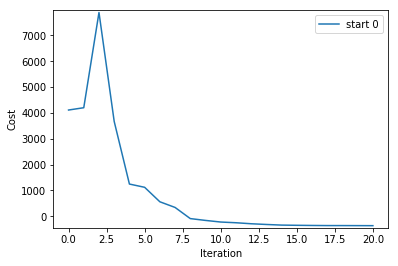

In [15]:
hdf5_pe_output_file_standard = 'deleteme/_rank00000.h5'
trajectories_standard = parpe.getCostTrajectories(hdf5_pe_output_file_standard)
parpe.plotting.plotCostTrajectory(trajectories_standard, log=False);

Since this example uses artificial data based on model simulations with known parameters, we can compare them to the optimization results:

In [16]:
parpe.compare_optimization_results_to_true_parameters(hdf5_pe_output_file_standard, start_idx='0')

#  __Exp____ __Act______ __Err______ __RelErr___ __ID_______
0:   1.00000     1.89231     0.89231     0.89231 p1
1:   0.50000     0.82602     0.32602     0.65205 p2
2:   0.40000     0.68143     0.28143     0.70359 p3
3:   2.00000     1.81545    -0.18455    -0.09227 p4
4:   0.10000     0.24917     0.14917     1.49165 p5
5:   2.00000     2.06308     0.06308     0.03154 scaling_x1_common
6:   3.00000     2.99325    -0.00675    -0.00225 offset_x2_batch-0
7:   0.20000     0.19805    -0.00195    -0.00974 x1withsigma_sigma
8:   4.00000     2.99338    -1.00662    -0.25165 offset_x2_batch-1

Status: 1
Cost: -365.274785 (expected: -0.000000)


In [17]:
# Simulate with optimal parameters, save results
!rm -f sim.h5 # remove files from previous run
!{example_binary_dir}/example_steadystate_multi_simulator {hdf5_pe_output_file_standard} / sim.h5 / --at-optimum

Running for start 0
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
Need to compute analytical parameters: //inputData  1 parameters.size() == 5 ; hierarchical.numParameters() == 5
Starting simulation. Number of conditions: 4


In [18]:
# Load simulated outputs
(measured, simulated, timepoints, llh) = parpe.readSimulationsFromFile('simh.h5')
start_idx = '0'

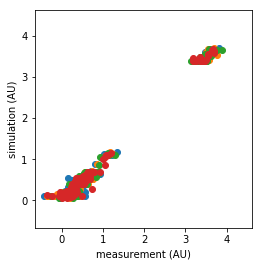

In [19]:
# Plot correlation of measurements (training data) and model simulation with optimized parameters 
parpe.plotting.plotCorrelation(measured[start_idx], simulated[start_idx])

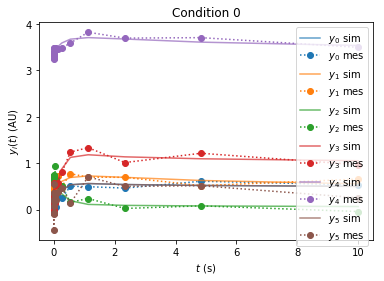

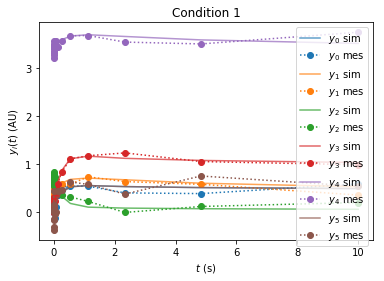

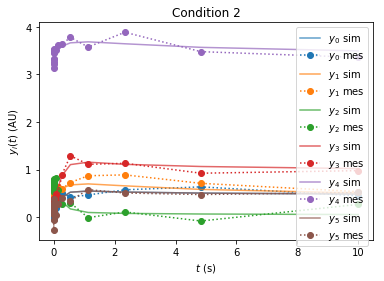

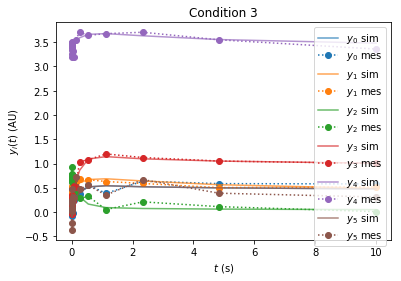

In [20]:
# Plot measurement trajectories (training data) and compare to model simulation with optimized parameters
parpe.plotting.plotTrajectoryFits(measured[start_idx], simulated[start_idx], timepoints[start_idx])

## Standard optimization vs. hierarchical optimization

### TODO

In [21]:
# Accuracy of parameter estimates

start_idx = '0'
print('Hierarchical:')
parpe.compare_optimization_results_to_true_parameters(hdf5_pe_output_file_hierarchical, start_idx=start_idx)
print()
print('Standard:')
parpe.compare_optimization_results_to_true_parameters(hdf5_pe_output_file_standard, start_idx=start_idx)

Hierarchical:
#  __Exp____ __Act______ __Err______ __RelErr___ __ID_______
0:   1.00000     0.88195    -0.11805    -0.11805 p1
1:   0.50000     0.70469     0.20469     0.40937 p2
2:   0.40000     0.29613    -0.10387    -0.25967 p3
3:   2.00000     1.98674    -0.01326    -0.00663 p4
4:   0.10000     0.17498     0.07498     0.74976 p5
5:   2.00000     2.10515     0.10515     0.05257 scaling_x1_common
6:   3.00000     2.98368    -0.01632    -0.00544 offset_x2_batch-0
7:   0.20000     0.20046     0.00046     0.00231 x1withsigma_sigma
8:   4.00000     2.98951    -1.01049    -0.25262 offset_x2_batch-1

Status: 1
Cost: -370.803762 (expected: -0.000000)

Standard:
#  __Exp____ __Act______ __Err______ __RelErr___ __ID_______
0:   1.00000     1.89231     0.89231     0.89231 p1
1:   0.50000     0.82602     0.32602     0.65205 p2
2:   0.40000     0.68143     0.28143     0.70359 p3
3:   2.00000     1.81545    -0.18455    -0.09227 p4
4:   0.10000     0.24917     0.14917     1.49165 p5
5:   2.00000  

The previous block shows, that parameters are recovered more accurately by the hierarchical optimization approach.